In [ ]:
pip install "numpy<2.0"

In [ ]:
conda install numpy=1.26

In [118]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [119]:
df = pd.read_csv("insurance.csv")
df


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [120]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [121]:
df_num = df.select_dtypes(include = "number")
df_num

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


In [122]:
df_num.corr(method = "spearman")

,age,bmi,children,charges
age,1.000000,0.107736,0.056992,0.534392
bmi,0.107736,1.000000,0.015607,0.119396
children,0.056992,0.015607,1.000000,0.133339
charges,0.534392,0.119396,0.133339,1.000000


In [123]:
target = df_num['charges']
target

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [124]:
df_num = df_num[['age', 'bmi', 'children']]
df_num

,age,bmi,children
0,19,27.900,0
1,18,33.770,1
2,28,33.000,3
3,33,22.705,0
4,32,28.880,0
...,...,...,...
1333,50,30.970,3
1334,18,31.920,0
1335,18,36.850,0
1336,21,25.800,0


In [125]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df_num)
x_scaled = pd.DataFrame(scaled)
y_scaled = scaler.fit_transform(target.values.reshape(-1,1))


In [126]:
encoder = OneHotEncoder(sparse_output=False) 
df_obj = df.select_dtypes(include = "object")
encoded = encoder.fit_transform(df_obj)
feature_names = df_obj.columns.tolist()
x_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(feature_names))


In [127]:
df_final = pd.concat([x_scaled, x_encoded], axis=1)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   0                 1338 non-null   float64
 1   1                 1338 non-null   float64
 2   2                 1338 non-null   float64
 3   sex_female        1338 non-null   float64
 4   sex_male          1338 non-null   float64
 5   smoker_no         1338 non-null   float64
 6   smoker_yes        1338 non-null   float64
 7   region_northeast  1338 non-null   float64
 8   region_northwest  1338 non-null   float64
 9   region_southeast  1338 non-null   float64
 10  region_southwest  1338 non-null   float64
dtypes: float64(11)
memory usage: 115.1 KB


In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [129]:
X_train, X_test, y_train, y_test = train_test_split(df_final, y_scaled, test_size=0.2, random_state=42)

In [130]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
# Define parameter grid
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"]
}

# Base model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,              # number of parameter settings sampled
    cv=5,                   # 5-fold cross-validation
    scoring="neg_mean_squared_error",
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
MSE: 0.14248961235750773
R²: 0.8655008527875226


In [131]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.14248961235750773
R²: 0.8655008527875226


In [136]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


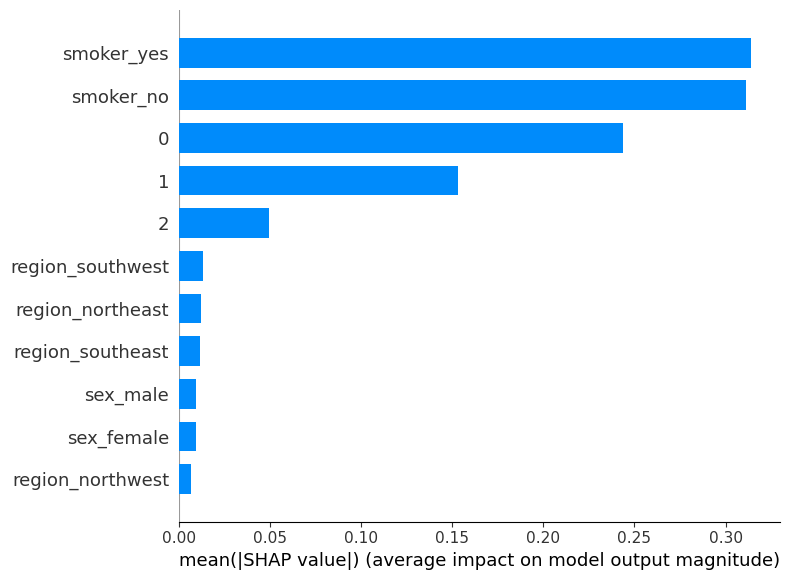

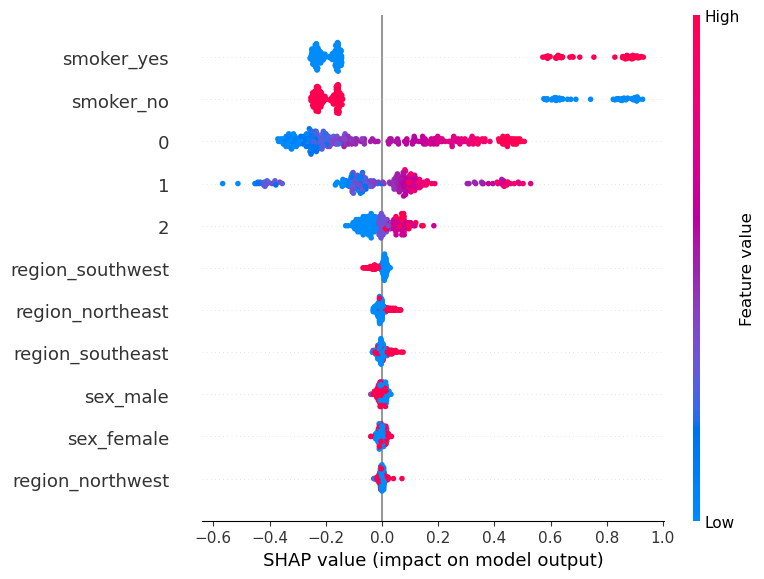

In [137]:
import shap
import matplotlib.pyplot as plt

# Initialize explainer for tree-based models
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# --- Global Interpretability ---
# Summary plot (impact of all features on predictions)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary (beeswarm plot)
shap.summary_plot(shap_values, X_test)

# --- Local Interpretability ---
# Explain a single prediction (first test sample)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])